# 利用 Paddle Quantum 的 `gate` 和 `channel` 模块构建量子操作

_Copyright (c) 2023 Institute for Quantum Computing, Baidu Inc. All Rights Reserved._

量桨的 `gate` 和 `channel` 模块可以用于构建量子操作。它们可以直接作用在一个 `State` 上或者插入到一个量子电路当中。量桨提供了方便的接口可以快速地创建常见的量子操作，用户也可以创建自定义操作。

In [12]:
import paddle_quantum
from paddle_quantum.ansatz import Circuit
from paddle_quantum.gate.custom import Oracle
from paddle_quantum.channel import *
from paddle_quantum.state.common import zero_state
from paddle_quantum.qinfo import qft_generation, random_channel
from paddle_quantum.linalg import dagger

## 自定义量子门
之前，我们已经看到如何创建一个量子门并将其插入到电路中。用户也可以使用 Oracle 类来实现自定义的量子门。

例如，考虑 n 量子比特下的傅里叶逆变换 (Inverse Quantum Fourier Transform, inverse QFT)，它是一个酉算符，其矩阵形式为

$$
\frac{1}{\sqrt{N}}\begin{pmatrix}
    1 & 1 & 1 & \ldots & 1  \\
    1 & \omega^{N-1} & \omega^{N-2} & \ldots & \omega \\
    1 & \omega^{2(N-1)} & \omega^{2(N-2)} & \ldots & \omega^2 \\
    \ldots & \ldots & \ldots & \ldots & \ldots \\
    1 & \omega^{(N-1)(N-1)} & \omega^{(N-1)(N-2)} & \ldots & \omega^{N-1}
\end{pmatrix}
$$

其中， $N=2^n$ 是系统的维度，$\omega = e^{2\pi i/N}$。

下面的代码创建了一个实现 2 比特傅里叶逆变换的 oracle 。

In [13]:
unitary = qft_generation(2) # 通过量桨内置函数得到2比特QFT的矩阵
unitary = dagger(unitary) # 通过量桨内置函数对矩阵进行共轭转置，得到 inverse QFT 的矩阵 （对于么正矩阵来说，共轭转置就是求逆的过程）
QFT_inverse = Oracle(unitary)

它是一个量子门，我们可以把它插入到一个量子电路当中并且打印电路。

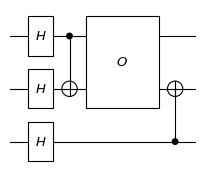

In [14]:
cir = Circuit(3)
cir.h()
cir.cnot([0,1])
cir.append(QFT_inverse) # 插入 oracle 
cir.cnot([2,1])
cir.plot()

**注意**：假如需要打印电路，那么它不能是不连续的（比如作用在第 1 和第 3 量子比特上），否则将报错。

用户可以通过改变 gate_info 的内容去修改打印电路时 oracle 的样式。

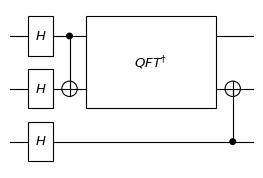

In [16]:
gate_info = {
    'texname': r'$QFT^{\dagger}$', # 更改打印的时候 oracle 的名字
    'plot_width': 1.5, # 调整打印的时候 oracle 的宽度
}
# 更新 oracle 的 gate_info
QFT_inverse.gate_info.update(gate_info)
# 创建和之前一样的电路
cir = Circuit(3)
cir.h()
cir.cnot([0,1])
cir.append(QFT_inverse) # 插入 oracle
cir.cnot([2,1])
cir.plot()

另外一种插入 oracle 的方法是在搭建电路的时候直接使用 `Circuit.oracle`。

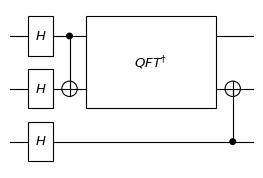

In [17]:
cir=Circuit(3)
cir.h()
cir.cnot([0,1])
# 直接使用 cir.oracle 去构建一个 oracle 门。构建的同时可以给出 gate_info 的自定义内容
cir.oracle(unitary, qubits_idx=[0,1], latex_name=r'$QFT^{\dagger}$', plot_width=1.5) 
cir.cnot([2,1])
cir.plot()

## 量子信道

量桨同时支持构建通用的量子操作，即构建量子信道。

构建信道的方法有两种。一种是通过量桨构建固定模式的信道，或者也可以构建一个自定义信道。

**注意**: `gate` 类可以在 `state_vecotr` 或 `density_matrix` 后端下运行，而 `channel` 只能在 `density_matrix` 后端运行。

In [18]:
paddle_quantum.set_backend('density_matrix') # 更改后端为 'density_matrix'

例如，我们可以构建一个比特反转信道，然后作用在 0 态上。常用信道的详细列表可参见 [量桨API](https://qml.baidu.com/api/paddle_quantum.channel.common.html)。

In [19]:
bit_flip_channel = BitFlip(prob=0.5, num_qubits=1) # 定义一个单比特比特反转信道，反转概率为 0.5
input = zero_state(1)
output = bit_flip_channel(input) # 作用信道在 0 态上
print(output)

[[0.49999997+0.j 0.        +0.j]
 [0.        +0.j 0.49999997+0.j]]


自定义信道可以通过其 Kraus, Stinespring 或者 Choi 表达式构建。下面我们展示如何使用这三种不同的表达方式构建一个自定义信道。我们使用量桨的内置函数去随机生成这些表达方式。

**注意**： 量桨里对 Choi 矩阵的定义是信道作用在第二个系统上，即
$$
    J(\Lambda) = \sum_{i,j} |i\rangle\langle j| \otimes \Lambda(|i\rangle\langle j|).
$$
其中，$\Lambda$ 表示信道。

In [20]:
# 随机生成一组 Kraus 算子
kraus = random_channel(num_qubits=1, target='Kraus') 
# 通过 Kraus 算子构建信道
custom_kraus = KrausRepr(kraus)

# 随机生成一个Stinespring 保距映射
stinespring = random_channel(num_qubits=1, target='Stinespring')
# 通过 Stinespring 保距映射构建信道
custom_stinespring = StinespringRepr(stinespring)

# 随机生成一个 Choi 矩阵
choi = random_channel(num_qubits=1, target='Choi')
# 通过 Choi 矩阵构建信道
custom_choi = ChoiRepr(choi)

之前看到我们可以把一个量子门插入到电路当中，我们同样也可以把一个信道以相同的方法插入到电路当中。不过，目前量桨并不支持打印含有信道的电路。

In [21]:
 # 默认情况下，信道会作用在第一个比特上。我们可以通过在构建信道的时候给出 qubits_idx 的值来指定它作用在哪个比特上。
custom_choi = ChoiRepr(choi, qubits_idx=[2])
cir = Circuit(3)
cir.append(bit_flip_channel) # 在电路的末尾插入信道
cir.h()
cir.insert(index=2, operator = custom_choi) # 在电路指定位置插入一个信道
cir.bit_flip(0.5, qubits_idx=[2]) # 在构建电路的时候直接构建信道